In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_label_units(dtype):
    """
    returns label and units for plotting aesthetics
    """
    if dtype=='dm':
        label = 'DM'
        units = '(pc cm'+r'$^{-3}$)'
    elif dtype=='width':
        label = 'Pulse width'
        units = '(s)'
    elif dtype=='scat':
        label = 'Scattering timescale'
        units = '(s)'
    else:
        raise ValueError('Invalid dtype')

    return label, units

def make_rgb_transparent(color, bg_rgb=(1,1,1), alpha=0.5):
    """https://stackoverflow.com/questions/33371939/calculate-rgb-equivalent-of-base-colors-with-alpha-of-0-5-over-white-background
    """
    from matplotlib import colors
    rgb = colors.colorConverter.to_rgb(color)
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

def poisson_68_err(x, CI_lvl=0.68):
    """
    formula from https://ms.mcmaster.ca/peter/s743/poissonalpha.html
    """
    from scipy.stats import chi2

    loerr = chi2.ppf((1-CI_lvl)/2, 2*x)/2
    loerr = np.array([0 if np.isnan(x) else x for x in loerr])
    
    uperr = chi2.ppf((1+CI_lvl)/2, 2*(x+1))/2
    uperr = np.array([0 if np.isnan(x) else x for x in uperr])

    return [loerr, uperr]

In [3]:
def get_shape_scale(dtype):
    """
    from chimefrb+2021 (catalog1 paper) table 4
    returns (shape,scale) tuple
    """
    if dtype=='dm':
        return  0.66,495.0
    elif dtype=='width':
        return  0.97,1.0/1000
    elif dtype=='scat':
        return 1.72,2.02/1000
    else:
        raise ValueError('Invalid dtype')

In [4]:
def plot_seleffects(dtype, scat_cut=10e-3):
    """
    plots the catalog distribution in data space and model space (i.e.,
    corrected by the selection function) for the lognormal distr. dtypes
    (DM, width, scattering)
    best-fit lines with poisson errors are overlaid, and the selection function
    is plotted in a subpanel as well.
    produces figures 16,17,18 in chimefrb+2021 (catalog1 paper)
    
    corrected_distrs.npz contains, for each dtype:
    n_wi: weighted histogram of all injections 
    n_wdi: weighted histogram of all detected injections
    n_ca: observed catalog data
    log_data_bins: the binnings for the histograms
    
    weights obtained through iterative fitting process described in paper
    (could be made available upon reasonable request)
    """
    from scipy.stats import lognorm
    import matplotlib.patches as mpatches

    label, units = get_label_units(dtype)
    col = make_rgb_transparent('C0', alpha=0.5)
    shape, scale = get_shape_scale(dtype)

    # retreiving data -- the reweighted distrs & selection
    cdistrs = np.load('corrected_distrs.npz')
    n_wi = cdistrs[f'{dtype}_n_wi']
    n_wdi = cdistrs[f'{dtype}_n_wdi']
    n_ca = cdistrs[f'{dtype}_n_ca']
    selection = (n_wdi / n_wi)
    cat_err = poisson_68_err(n_ca)
    
    log_data_bins = cdistrs[f'{dtype}_log_data_bins']
    log_data_pts = (log_data_bins[1:] + log_data_bins[:-1]) / 2
    cat_data = np.array([]) # fake constructing for the histogram
    for pt, num in zip(log_data_pts, n_ca):
        cat_data = np.append(cat_data, [pt]*num)

    # fitting best-fit model, and multiplying by selection
    fit_model_tmp = lognorm.pdf(log_data_pts, s=shape, loc=0, scale=scale)
    fit_model_tmp *= selection
    fit_model_tmp *= np.diff(log_data_bins)
    fit_model = fit_model_tmp/(np.sum(fit_model_tmp)/n_ca.sum())

    ## plotting
    f = plt.figure(figsize=(12,6))
    N, M = 8, 12
    gs = f.add_gridspec(N,M)
    ax0 = f.add_subplot(gs[:N//4, :M//2])
    ax1 = f.add_subplot(gs[N//4:, :M//2], sharex=ax0)
    ax2 = f.add_subplot(gs[:, M//2:])
    
    for i, ax in enumerate([ax0, ax1, ax2]):
        if i==0:
            norm_factor_tmp = np.trapz(fit_model/np.diff(log_data_bins), x=log_data_pts)
            selection_plot = selection / (np.sum(fit_model_tmp)/n_ca.sum()) / norm_factor_tmp

            ax.set_ylabel('Selection', fontsize=13)
            ax.tick_params(labelbottom=False)
            ax.plot(log_data_bins, np.concatenate((selection_plot, [selection_plot[-1]])),
                drawstyle='steps-post', color='k')
            ax.locator_params(axis='y', nbins=4)

        if i==1:
            ## <data space>
            ax.set_ylabel('Counts', fontsize=13)
            
            # catalog
            ax.hist(cat_data, bins=log_data_bins, color=col, edgecolor='white', lw=1, zorder=2)
            
            if dtype=='scat':
                cutoff_ii = np.where(log_data_bins<=scat_cut)[0][-1]
                # fit model * selection
                p3, = ax.plot(log_data_bins[:cutoff_ii+1], np.concatenate((fit_model[:cutoff_ii], [fit_model[cutoff_ii-1]])),
                    color='k', zorder=5, drawstyle='steps-post', lw=3)

                # catalog err bars
                p1 = ax.errorbar(log_data_pts, n_ca, fmt='none', color='C0', zorder=4,
                    yerr=(n_ca-cat_err[0], cat_err[1]-n_ca))

                # legend
                p2 = mpatches.Patch(color='C0', alpha=0.5, linewidth=0)
                ax.legend( ((p3), (p1,p2),), ('Fiducial model '+r'$\times$'+' selection', 'Raw catalog',),
                    framealpha=1.0, loc='upper right', fontsize=13)

            else:
                # catalog err bars
                p1 = ax.errorbar(log_data_pts, n_ca, fmt='none', color='C0', zorder=4,
                    yerr=(n_ca-cat_err[0], cat_err[1]-n_ca), label='Poisson uncertainty')
                
                # fit model * selection
                p3, = ax.plot(log_data_bins, np.concatenate((fit_model, [fit_model[-1]])),
                    zorder=5, color='k', drawstyle='steps-post', lw=3)

                # legend
                p2 = mpatches.Patch(color='C0', alpha=0.5, linewidth=0)
                if dtype == 'width':
                    ax.legend( ((p3), (p1,p2),), ('Fiducial model '+r'$\times$'+' selection', 'Raw catalog',),
                        framealpha=1.0, loc='upper left', fontsize=13)
                else:    
                    ax.legend( ((p3), (p1,p2),), ('Fiducial model '+r'$\times$'+' selection', 'Raw catalog',),
                        framealpha=1.0, loc='best', fontsize=13)

        elif i==2:
            ## <best-fit model space>. dividing out the bin width for PDF
            ax.set_ylabel(f'{label} '+r'$\times$'+' Probability density', fontsize=13)

            # catalog / selection function  & err bars
            cat_with_sel = (n_ca / selection) / np.diff(log_data_bins)
            cat_err_2 = (cat_err / selection) / np.diff(log_data_bins)

            # fit model, dividing out the selection
            fit_model /= selection 
            fit_model /= np.diff(log_data_bins)

            # normalizing s.t. fit model integrates to 1
            norm_factor = np.trapz(fit_model, x=log_data_pts)
            fit_model /= norm_factor
            cat_with_sel /= norm_factor
            cat_err_2 /= norm_factor

            # catalog / selection
            ax.bar(log_data_pts, height=log_data_bins[:-1]*cat_with_sel,
                width=np.diff(log_data_bins), color=col, ecolor='C0', edgecolor='white',
                yerr=(log_data_bins[:-1]*(cat_with_sel-cat_err_2[0]), 
                      log_data_bins[:-1]*(cat_err_2[1]-cat_with_sel)))

            if dtype=='scat':

                # fit model
                cutoff_ii = np.where(log_data_bins<=scat_cut)[0][-1]
                ax.plot(log_data_bins[:cutoff_ii+1],
                    np.concatenate(((log_data_bins[:-1]*fit_model)[:cutoff_ii], [(log_data_bins[:-1]*fit_model)[cutoff_ii-1]])),
                    zorder=5, color='k', drawstyle='steps-post', lw=3)
                
                ax.legend( ((p3), (p1,p2),), ('Fiducial model', 'Selection-corrected catalog',),
                    framealpha=1.0, loc='upper left', fontsize=13)

            else:

                # fit model
                ax.plot(log_data_bins,
                    np.concatenate((log_data_bins[:-1]*fit_model, [(log_data_bins[:-1]*fit_model)[-1]])),
                    zorder=5, color='k', drawstyle='steps-post', lw=3)

                if dtype=='width':
                    ax.legend( ((p3), (p1,p2),), ('Fiducial model', 'Selection-corrected catalog',),
                        framealpha=1.0, loc='upper left', fontsize=13)
                else:
                    ax.legend( ((p3), (p1,p2),), ('Fiducial model', 'Selection-corrected catalog',),
                        framealpha=1.0, loc='best', fontsize=13)


        ax.set_xscale('log')
        ax.set_xlabel(f'{label} {units}', fontsize=13)
        if dtype == 'width':
            if i==1:
                ax.set_ylim(ymax = ax.get_ylim()[1]*1.3)

        if dtype == 'dm':
            if i==1:
                ax.set_ylim(ymax = ax.get_ylim()[1]*1.3)
            elif i==2:
                ax.set_ylim(ymax = ax.get_ylim()[1]*1.2)

        if dtype == 'scat':
            if i==1:
                ax.set_ylim(ymax = ax.get_ylim()[1]*1.1)

        if dtype == 'scat' and i != 0:
            ax.axvline(scat_cut, color='k', ls=':')
            ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
            ax.fill_between([scat_cut, 2e-1], ymin, ymax, edgecolor='k', facecolor='k', alpha=0.1, zorder=1)
            ax.set_xlim(xmax=2e-1)
            ax.set_ylim(ymax=ymax)

        ax.set_ylim(ymin=0)

    plt.subplots_adjust(hspace=0, wspace=6, left=0.06, right=0.97, top=0.94, bottom=0.09)
    plt.show()
    plt.close()

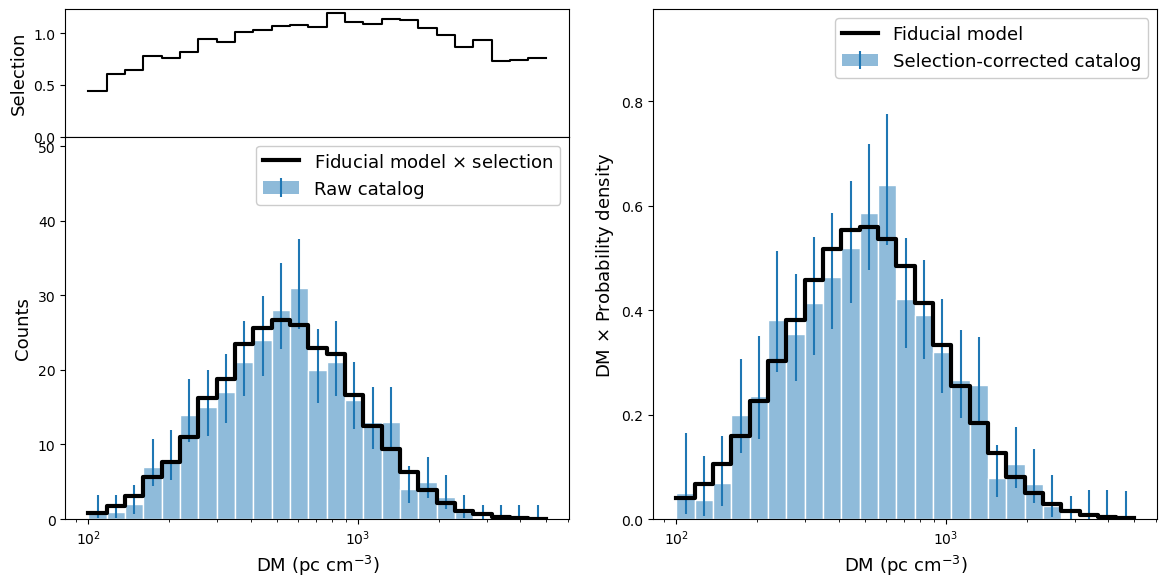

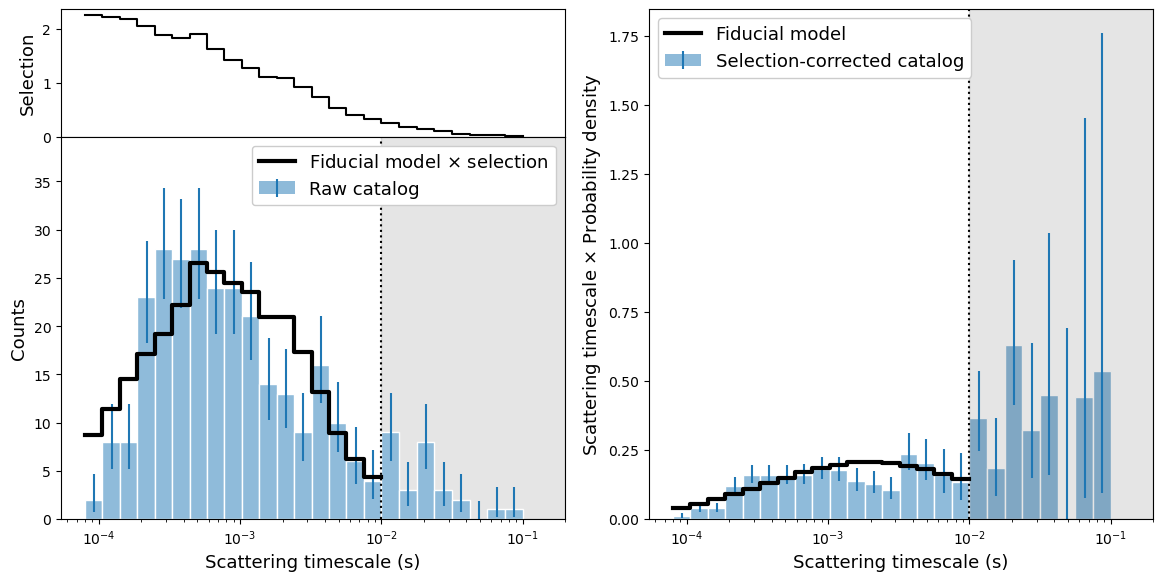

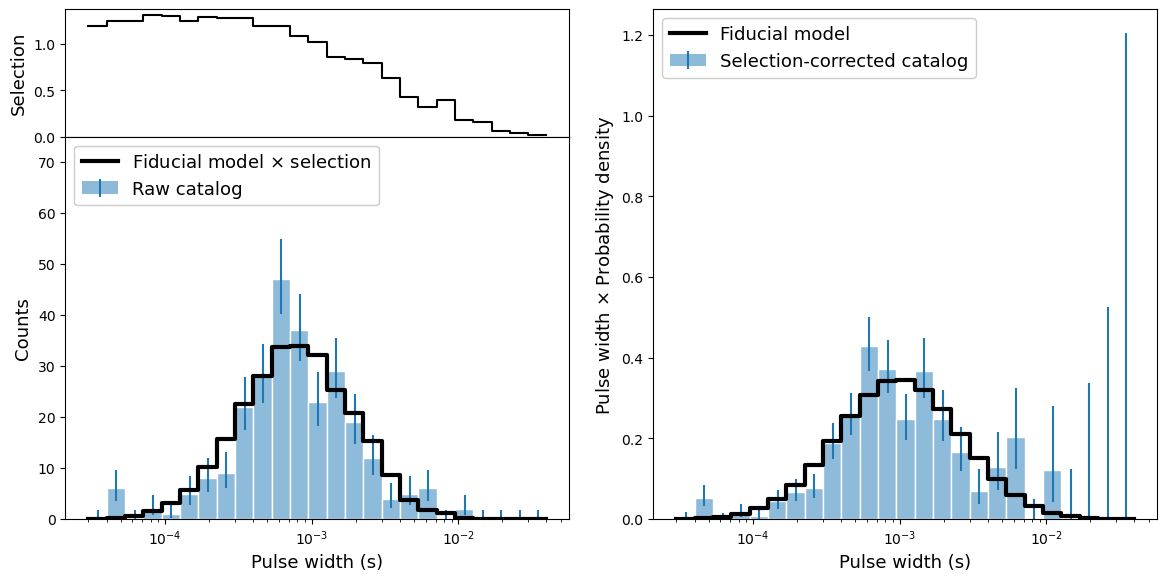

In [5]:
for dtype in ['dm', 'scat', 'width']:
    plot_seleffects(dtype)